# Исследовательский анализ данных сервиса бронирования билетов Яндекс.Афиша в Python и проверка гипотез

 - Выполнил: Матвеев Даниил, группа da-123.
 - Дата: 07.10.2025 г.

## Цель проекта

Провести исследовательский анализ данных сервиса бронирования билетов Яндекс.Афиша за период с 1 июня по 30 октября 2024 года, чтобы выяснить причины изменений в пользовательском спросе, определить ключевые факторы, влияющие на популярность мероприятий, и проанализировать активность пользователей, как с мобильных, так и с десктопных устройств. В результате анализа будет произведено сравнение сезонных изменений, выделение лидеров по выручке, а также определение особенностей поведения пользователей в зависимости от различных факторов, таких как тип мероприятия, устройство, возрастное ограничение и прочее.

## Задачи проекта

 - изучить, какие факторы влияют на изменение потребительского спроса
 - определить наиболее востребованные категории мероприятий, выявить перспективные для осенне-зимнего сезона категории
 - определить, какие партнеры и регионы приносят большую долю выручки, выявить потенциал для роста
 - выявить отличия между пользователями десктопных и мобильных устройств, определить их паттерн в отношении покупок билетов

## Описание данных

Анализ предстоит провести с использованием трех подготовленных датасетов.

Датасет final_tickets_orders_df.csv включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

 - order_id — уникальный идентификатор заказа.
 - user_id — уникальный идентификатор пользователя.
 - created_dt_msk — дата создания заказа (московское время).
 - created_ts_msk — дата и время создания заказа (московское время).
 - event_id — идентификатор мероприятия из таблицы events.
 - cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
 - age_limit — возрастное ограничение мероприятия.
 - currency_code — валюта оплаты, например rub для российских рублей.
 - device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
 - revenue — выручка от заказа.
 - service_name — название билетного оператора.
 - tickets_count — количество купленных билетов.
 - total — общая сумма заказа.
 - days_since_prev - количеством дней с предыдущей покупки для каждого пользователя.

Датасет final_tickets_events_df.csv содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

 - event_id — уникальный идентификатор мероприятия.
 - event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
 - event_type_description — описание типа мероприятия.
 - event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
 - organizers — организаторы мероприятия.
 - region_name — название региона.
 - city_name — название города.
 - venue_id — уникальный идентификатор площадки.
 - venue_name — название площадки.
 - venue_address — адрес площадки.

Датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год.

 - nominal — номинал (100 тенге).
 - data — дата.
 - curs — курс тенге к рублю.
 - cdx — обозначение валюты (kzt).

## Содержание проекта

5. Знакомство с данными
6. Предобработка данных
 - 6.1 Проверка на пропуски
 - 6.2 Проверка корректности категориальных данных и поиск аномалий
 - 6.3 Проверка на явные и неявные дубли
 - 6.4 Преобразование и оптимизация типов данных
 - 6.5 Создание новых столбцов
7. Исследовательский анализ данных
 - 7.1 Анализ распределения заказов по сегментам и их сезонные изменения
 - 7.2 Осенняя активность пользователей
 - 7.3 Популярные события и партнёры
8. Статистический анализ данных
 - 8.1 Проверка гипотезы о равенстве среднего количества заказов различных устройств
 - 8.2 Проверка гипотезы о равенстве среднего времени между заказами различных устройств
9. Итоговый вывод и рекомендации

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import mannwhitneyu
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
df_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
df_orders.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
df_events.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [7]:
df_tenge.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Промежуточные выводы по знакомству с данными:

 - в датафрейме df_orders 290 849 строк и 14 столбцов. Все столбцы, кроме days_since_prev, без пропусков, что не потребует дальнейшей обработки. Столбец days_since_prev не заполняем, так как понятна закономерность для появления пропусков (это первая покупка у этого пользователя). Столбец created_dt_msk не приведен к типу даты, days_since_prev представлен в виде числа с плавающей точкой, что тоже странно, больше подойдет integer. Остальные числовые столбцы можно оптимизировать (уменьшим разрядность). Данные соответствуют описанию.
 
 - в датафрейме df_events 22 427 строк и 11 столбцов. В столбцах нет пропусков. Все типы данных корректные. Возможно следует сделать также оптимизацию числовых данных. Данные соответствуют описанию.
 
 - в датафрейме df_tenge 357 строк и 4 столбца.  В этой таблице, нет особо никаких проблем - только нужно будет изменить тип данных у столбца с датой и также оптимизировать числовые столбцы. Данные тоже соответствуют описанию.

## Предобработка данных

### Пропуски

Проверим пропуски:

In [9]:
print("Пропуски в orders:")
print(df_orders.isna().sum())

print("\nПропуски в events:")
print(df_events.isna().sum())

print("\nПропуски в tenge:")
print(df_tenge.isna().sum())

Пропуски в orders:
order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

Пропуски в events:
event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

Пропуски в tenge:
data       0
nominal    0
curs       0
cdx        0
dtype: int64


Промежуточный итог: пропуски только в days_since_prev.

Объединим 2 датасета для дальнейшего анализа и посмотрим на количество строк в результатирующем датафрейме, проверим на пропуски после объединения:

In [10]:
df = df_orders.merge(df_events, on='event_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

In [11]:
print(df.isna().sum())

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64


Заменим образовавшиеся пропуски значениями и заглушками:

In [12]:
event_cols = ['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name','city_name', 'venue_name', 
              'venue_address']
df[event_cols] = df[event_cols].fillna("unknown")

df['city_id'] = df['city_id'].fillna(-1).astype(int)
df['venue_id'] = df['venue_id'].fillna(-1).astype(int)

In [13]:
df.dtypes

order_id                    int64
user_id                    object
created_dt_msk             object
created_ts_msk             object
event_id                    int64
cinema_circuit             object
age_limit                   int64
currency_code              object
device_type_canonical      object
revenue                   float64
service_name               object
tickets_count               int64
total                     float64
days_since_prev           float64
event_name                 object
event_type_description     object
event_type_main            object
organizers                 object
region_name                object
city_name                  object
city_id                     int64
venue_id                    int64
venue_name                 object
venue_address              object
dtype: object

In [14]:
print("Пропуски после обработки:")
print(df.isna().sum())

print("Доля пропусков после обработки:")
print((df.isna().mean() * 100).round(2))

Пропуски после обработки:
order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64
Доля пропусков после обработки:
order_id                  0.00
user_id                   0.00
created_dt_msk            0.00
created_ts_msk            0.00
event_id                  0.00
cinema

### Дубликаты

Проверим созданный датасет на явные и неявные дубликаты:

In [15]:
print(f'Явных дубликатов: {len(df[df.duplicated()])}')
df = df.drop_duplicates()

Явных дубликатов: 0


In [16]:
df.columns

Index(['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address'],
      dtype='object')

In [17]:

print(f'Число записей о заказах до предобработки: {len(df)}')
dl = len(df)
df = df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address'], keep='first')
print(f'Число записей о заказах после предобработки: {len(df)}, неявных дубликатов (удалено): {dl - len(df)}')

Число записей о заказах до предобработки: 290849
Число записей о заказах после предобработки: 290819, неявных дубликатов (удалено): 30


Промежуточный вывод: явные дубликаты проверены, с ними все понятно. По неявным - причиной их поиска и предоработки является знакомство с данными на других этапах. Логично предположить, что в большом сервисе могут быть технические ошибки, которые искажают дальнейший анализ. Проведена обработка по поиску большинства столбцов и оставлена первая запись какого-либо заказа пользователя. 

### Категориальные данные

Проверим категориальные данные. В итоговом датафрейме для проверки корректности категориальных данных нас интересует 9 столбцов: cinema_curcuit, currency_code, device_type_canonnical, service_name, event_type_description, event_type_main, region_name, city_name, venue_name. Для начала оценим, сколько уникальных значений в каждом столбце:

In [18]:
for col in ['cinema_circuit', 'currency_code', 'device_type_canonical', 
            'service_name', 'event_type_description', 'event_type_main',
            'region_name', 'city_name', 'venue_name']:
    unique_values = df[col].nunique()
    print(f'В столбце {col} - {unique_values} уникальных категориальных значений')

В столбце cinema_circuit - 6 уникальных категориальных значений
В столбце currency_code - 2 уникальных категориальных значений
В столбце device_type_canonical - 2 уникальных категориальных значений
В столбце service_name - 36 уникальных категориальных значений
В столбце event_type_description - 21 уникальных категориальных значений
В столбце event_type_main - 8 уникальных категориальных значений
В столбце region_name - 82 уникальных категориальных значений
В столбце city_name - 353 уникальных категориальных значений
В столбце venue_name - 3218 уникальных категориальных значений


In [19]:
for col in ['cinema_circuit', 'currency_code', 'device_type_canonical', 
            'service_name', 'event_type_description', 'event_type_main', 'region_name', 'city_name', 'venue_name']:
    display(df.groupby(col, as_index=False)['order_id'].count().sort_values(by='order_id', ascending=False))

,cinema_circuit,order_id
5,нет,289421
0,Другое,1261
1,КиноСити,122
2,Киномакс,7
3,Москино,7
4,ЦентрФильм,1


,currency_code,order_id
1,rub,285750
0,kzt,5069


,device_type_canonical,order_id
1,mobile,232658
0,desktop,58161


,service_name,order_id
3,Билеты без проблем,63696
21,Лови билет!,41122
5,Билеты в руки,40359
24,Мой билет,34840
25,Облачко,26642
22,Лучшие билеты,17793
8,Весь в билетах,16849
26,Прачечная,10273
19,Край билетов,6207
30,Тебе билет!,5227


,event_type_description,order_id
3,концерт,112045
12,событие,58597
13,спектакль,50584
18,шоу,13625
14,спорт,12832
6,мюзикл,9919
15,спортивное мероприятие,9074
1,балет,5998
2,выставка,5874
17,цирковое шоу,5325


,event_type_main,order_id
3,концерты,115272
6,театр,67313
2,другое,65855
4,спорт,21906
5,стендап,13393
1,выставки,4853
7,ёлки,1989
0,unknown,238


,region_name,order_id
24,Каменевский регион,91049
61,Североярская область,44043
78,Широковская область,16457
43,Медовская область,13898
46,Озернинский край,10476
...,...,...
34,Лесноярский край,19
33,Крутоводский регион,18
6,Верхозёрский край,11
67,Сосноводолинская область,10


,city_name,order_id
41,Глиногорск,89437
197,Озёрск,43904
234,Радужсвет,13708
231,Радужнополье,8741
31,Верховино,6579
...,...,...
9,Байсары,1
320,Травино,1
285,Синеполинск,1
287,Солнечегорск,1


,venue_name,order_id
2229,"Студия дизайна ""Платформа"" Инкорпорэйтед",9907
710,"Картинная галерея ""Светлячок"" Лтд",4405
1310,"Креативное пространство ""Вдох"" Лимитед",4256
2901,"Центр культурного наследия ""Заряд"" и партнеры",4098
2226,"Студия дизайна ""Лестница"" Лимитед",4024
...,...,...
2290,"Сценический центр ""Скворечник"" и партнеры",1
2844,"Фонд искусств ""Лавка"" Лимитед",1
2291,"Сценический центр ""Созидание"" Инк",1
2842,"Фонд искусств ""Жемчуг"" Лимитед",1


Промежуточный вывод: с категориями в столбцах все в порядке. 

В столбце cinema_circuit 289451 строк содержат заглушку "нет", обозначающие пропуски в данных или отсутствие информации. 
В столбцах event_type_description и event_type_main - значения "событие" и "другое" имеют достаточно много заказов на счету, но сами эти значения не дают никакой информации. Получается, что определённые заказы не дают какой-либо идентификации по этим столбцам. 



### Количественные данные

Проанализируем количественные данные: посмотрим на статистические данные, распределения и выбросы в столбцах revenue и tickets_count.

In [20]:
print(df['revenue'].describe(percentiles=[.95, .99]))
print(df['tickets_count'].describe(percentiles=[.95, .99]))
print(df['total'].describe(percentiles=[.95, .99]))
print(df['age_limit'].describe(percentiles=[.95, .99]))

count    290819.000000
mean        625.112946
std        1227.368227
min         -90.760000
50%         355.340000
95%        1744.990000
99%        4000.190000
max       81174.540000
Name: revenue, dtype: float64
count    290819.000000
mean          2.754256
std           1.170461
min           1.000000
50%           3.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64
count    290819.000000
mean       7526.802288
std       15328.956797
min        -358.850000
50%        4771.390000
95%       17858.981000
99%       61647.160000
max      811745.400000
Name: total, dtype: float64
count    290819.000000
mean         10.211499
std           6.518034
min           0.000000
50%          12.000000
95%          18.000000
99%          18.000000
max          18.000000
Name: age_limit, dtype: float64


Конкретно по выручке проведем разделение на валюты, поскольку эти цифры важны и отличие в курсе между ними может немного исказить данные. Разделим выручку на рубли и тенге:

In [21]:
rub_df = df[df['currency_code'] == 'rub']
kzt_df = df[df['currency_code'] == 'kzt']

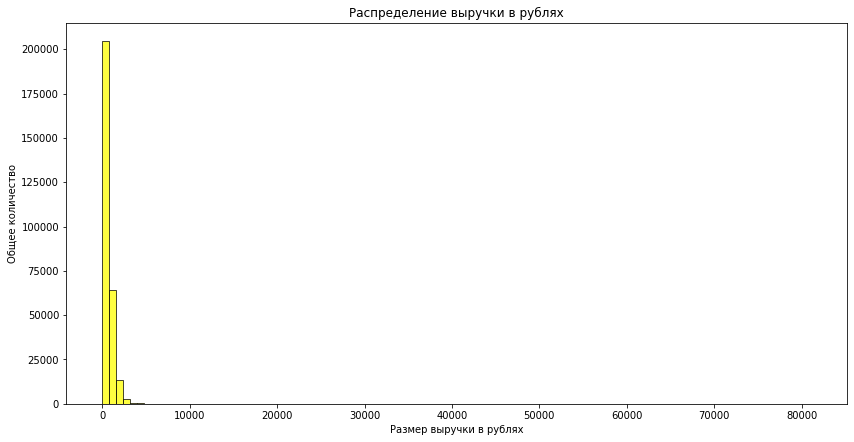

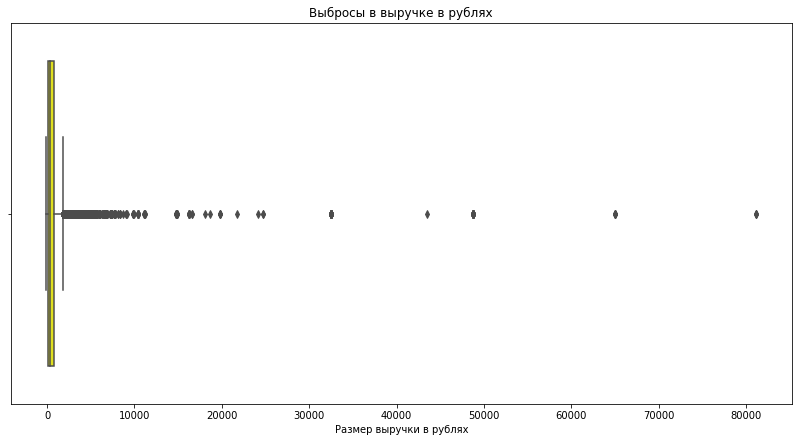

In [22]:
plt.figure(figsize=(14, 7))

sns.histplot(data=rub_df, x='revenue', bins=100, color='yellow')
plt.title('Распределение выручки в рублях')
plt.xlabel('Размер выручки в рублях')
plt.ylabel('Общее количество')


plt.figure(figsize=(14, 7))
sns.boxplot(x=rub_df['revenue'], color='yellow')
plt.title('Выбросы в выручке в рублях')
plt.xlabel('Размер выручки в рублях');

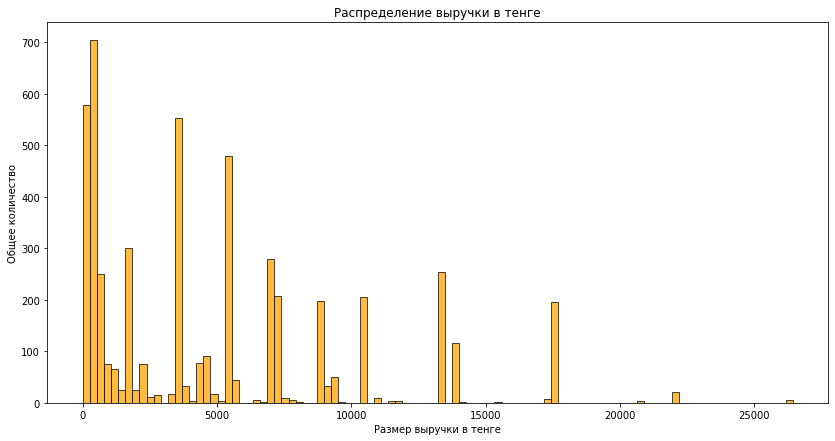

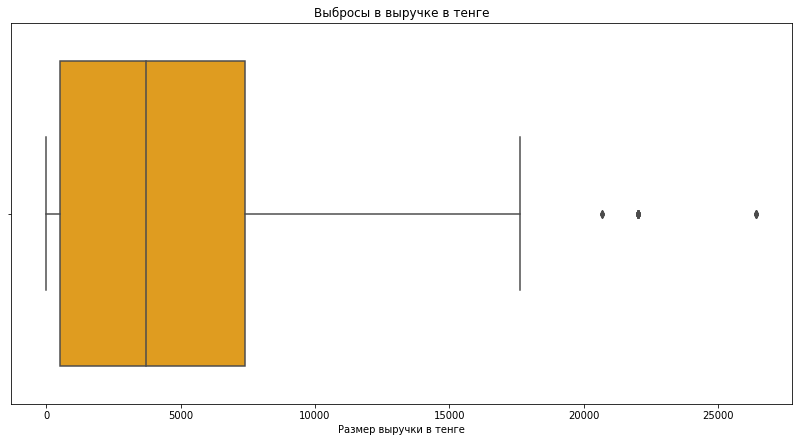

In [23]:
plt.figure(figsize=(14, 7))

sns.histplot(data=kzt_df, x='revenue', bins=100, color='orange')
plt.title('Распределение выручки в тенге')
plt.xlabel('Размер выручки в тенге')
plt.ylabel('Общее количество')


plt.figure(figsize=(14, 7))
sns.boxplot(x=kzt_df['revenue'], color='orange')
plt.title('Выбросы в выручке в тенге')
plt.xlabel('Размер выручки в тенге');

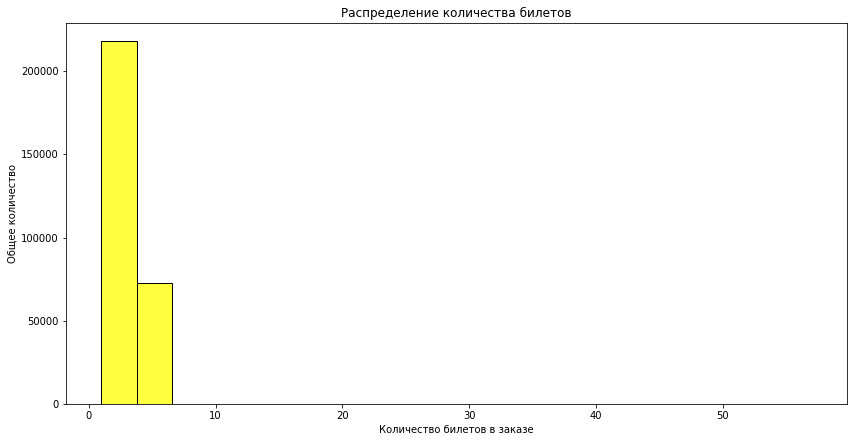

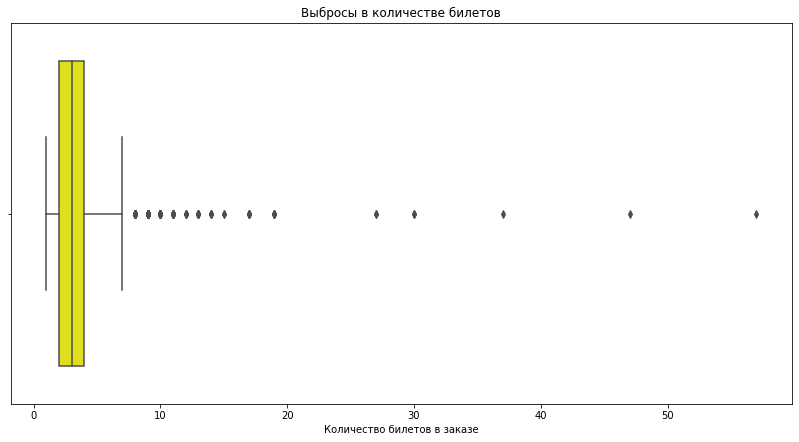

In [24]:
plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='tickets_count', bins=20, color='yellow')
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Общее количество')


plt.figure(figsize=(14, 7))
sns.boxplot(x=df['tickets_count'], color='yellow')
plt.title('Выбросы в количестве билетов')
plt.xlabel('Количество билетов в заказе');

Промежуточный вывод: отрицательные значения в столбцах revenue и total - это возвраты или отмены бронирований. Видно, что в данных явно присутствуют выбросы - средние значительно отличаются от медианы, максимальные значения высокие. Необходимо провести фильтрацию данных по 99 процентилю в важных столбцах - revenue и tickets_count. Поскольку после разделения выручки и обоих валютах образовались выбросы, то сокращение произведем из общего датасета, который учитывает все данные. Объединение kzt_df и rub_df пропущено, а было сформировано лишь для более детального анализа. 

In [25]:
rub_revenue_99perc = rub_df['revenue'].quantile(0.99)
kzt_revenue_99perc = kzt_df['revenue'].quantile(0.99)

rub_df_filtered = rub_df[rub_df['revenue'] <= rub_revenue_99perc]
kzt_df_filtered = kzt_df[kzt_df['revenue'] <= kzt_revenue_99perc]

df_f = pd.concat([rub_df_filtered, kzt_df_filtered])

print(f"99-й процентиль для RUB: {rub_revenue_99perc:.2f}")
print(f"99-й процентиль для KZT: {kzt_revenue_99perc:.2f}")
print(f"Размер исходного датасета: {len(df)}")
print(f"Размер отфильтрованного датасета: {len(df_f)}")
print(f"Удалено записей: {len(df) - len(df_f)}")

99-й процентиль для RUB: 2569.60
99-й процентиль для KZT: 17617.24
Размер исходного датасета: 290819
Размер отфильтрованного датасета: 287932
Удалено записей: 2887


In [61]:
tickets_99perc = df_f['tickets_count'].quantile(0.99)

df = df_f[df_f['tickets_count'] <= tickets_99perc]

### Преобразование типов данных

Преобразуем типы данных:

In [27]:
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])
df['age_limit'] = pd.to_numeric(df['age_limit'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['total'] = pd.to_numeric(df['total'], downcast='float')


df_tenge['nominal'] = pd.to_numeric(df_tenge['nominal'], downcast='integer')
df_tenge['curs'] = pd.to_numeric(df_tenge['curs'], downcast='float')
df_tenge['data'] = pd.to_datetime(df_tenge['data'])

print(df.dtypes)
print(df_tenge.dtypes)

order_id                           int64
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int64
cinema_circuit                    object
age_limit                           int8
currency_code                     object
device_type_canonical             object
revenue                          float32
service_name                      object
tickets_count                       int8
total                            float32
days_since_prev                  float64
event_name                        object
event_type_description            object
event_type_main                   object
organizers                        object
region_name                       object
city_name                         object
city_id                            int64
venue_id                           int64
venue_name                        object
venue_address                     object
dtype: object
da

### Создание новых столбцов

Соединим датасеты и приведем валюту к рублю. Создадии новые столбцы: 
 - revenue_rub — выручка с заказа в российском рубле;
 - one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие;
 - month — месяц оформления заказа;
 - season — столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.
 


In [28]:
df = df.merge(
    df_tenge[['data', 'curs']], 
    left_on=df['created_dt_msk'].dt.date,
    right_on=df_tenge['data'].dt.date,
    how='left')

df['revenue_rub'] = np.where(
    df['currency_code'] == 'kzt',
    df['revenue'] * (df['curs'] / 100),
    df['revenue'])

df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

df['month'] = df['created_dt_msk'].dt.month

def season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

df['season'] = df['month'].apply(season)

df.head(10)

,key_0,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,...,city_id,venue_id,venue_name,venue_address,data,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,2024-08-20,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,...,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.697201,1521.939941,380.484985,8,Лето
1,2024-07-23,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,...,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.341900,289.450012,144.725006,7,Лето
2,2024-10-06,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,...,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.647499,1258.569946,314.642487,10,Осень
3,2024-07-13,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,...,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.500999,8.490000,4.245000,7,Лето
4,2024-10-04,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,...,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.664801,1390.410034,463.470001,10,Осень
5,2024-10-23,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,...,193,930,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",2024-10-23,20.053101,902.739990,300.913330,10,Осень
6,2024-08-15,6636941,00096d1f542ab2b,2024-08-15,2024-08-15 16:48:48,201953,нет,16,rub,desktop,...,213,4035,"Выставка ремесел ""Платформа"" Групп","алл. Горняцкая, д. 573",2024-08-15,18.773001,917.830017,229.457504,8,Лето
7,2024-09-29,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,...,18,3159,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",2024-09-29,19.374100,47.779999,47.779999,9,Осень
8,2024-10-15,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,...,18,3159,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",2024-10-15,19.718500,74.839996,37.419998,10,Осень
9,2024-06-20,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,нет,12,rub,mobile,...,35,4471,"Киновидеостудия ""Тон"" и партнеры","ул. Тихая, д. 69 стр. 669",2024-06-20,18.041901,1421.910034,355.477509,6,Лето


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290631 entries, 0 to 290630
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   key_0                   290631 non-null  object        
 1   order_id                290631 non-null  int64         
 2   user_id                 290631 non-null  object        
 3   created_dt_msk          290631 non-null  datetime64[ns]
 4   created_ts_msk          290631 non-null  datetime64[ns]
 5   event_id                290631 non-null  int64         
 6   cinema_circuit          290631 non-null  object        
 7   age_limit               290631 non-null  int8          
 8   currency_code           290631 non-null  object        
 9   device_type_canonical   290631 non-null  object        
 10  revenue                 290631 non-null  float32       
 11  service_name            290631 non-null  object        
 12  tickets_count           290631

Промежуточный вывод:
 - Удалено 1% данных (выбросы). Итоговый объем - 287 725 строк;
 - Объеденены датафреймы df_orders, df_events в один df;
 - Пропуски: days_since_prev ~ 8%, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данныe; в строковых столбцах event_name, event_type_description, event_type_main, organizers, region_name, city_name, venue_name, venue_address, для которых event_id не найдены;
 - Столбцы с датами created_dt_msk,created_ts_msk, data преобразованы в тип datetime;
 - Оптимизирована размерность в столбцах age_limit,tickets_count, revenue, total;
 - В количественных столбцах revenue и total c выручкой и общей суммой заказа выявлены отрицательные значения, которые могли быть образованы в результате возвратов билетов или отмен заказов;
 - По столбцу revenue с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив репрезентативность;
 - Дубликаты: явных нет, неявные - 30 (удалены);
 - Созданы новые столбцы: revenue_rub — выручка с заказа к единой валюте (российский рубль),one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие, month — месяц оформления заказа, season — сезон.
 
 Датасет готов для исследовательского анализа.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

Начнем с месячной динамики заказов:

,Количество заказов
Месяц,
6,34658
7,40895
8,45003
9,69929
10,100146


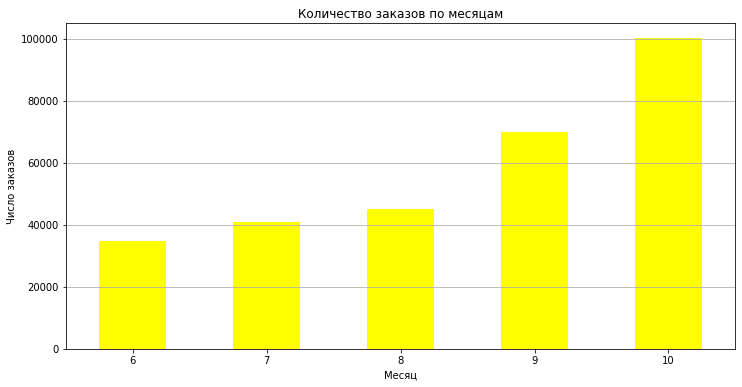

Разница в количестве заказов в июне и октябре 2024 в процентах - 188.95%


In [30]:
month_orders = df.groupby('month')['order_id'].count()
display(month_orders.to_frame('Количество заказов').rename_axis('Месяц'))


plt.figure(figsize=(12, 6))
month_orders.plot(kind='bar', color='yellow')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

month_change = df.groupby('month', as_index=False)['order_id'].count()
diff = month_change[month_change['month'] == 10]['order_id'].values[0] / month_change[month_change['month'] == 6]['order_id'].values[0] - 1
print(f'Разница в количестве заказов в июне и октябре 2024 в процентах - {diff:.2%}')

Промежуточный вывод: отчетливо виден рост количества заказов к осени. Причем в процентном соотношении от июня к ноябрю - рост большее 200%.

Рассмотрим сезонное распределение билетов по типам мероприятий, типам устройства, категориям мероприятия по возрастному рейтингу. В расчете будут отражены доли, так как в абсолютных значениях могут быть большие диапазоны. 

Начнем с типов мероприятий:

,Лето,Осень
unknown,0.2,0.0
выставки,2.0,1.4
другое,27.0,19.5
концерты,42.7,37.5
спорт,2.5,11.1
стендап,5.3,4.1
театр,20.1,25.3
ёлки,0.2,1.0


<Figure size 864x432 with 0 Axes>

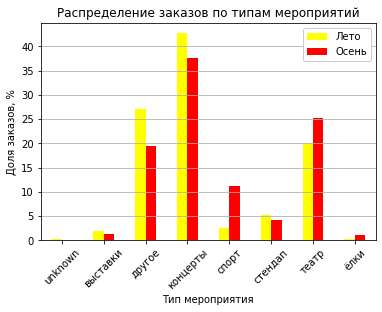

In [31]:
summer = df[df['season'] == 'Лето']
autumn = df[df['season'] == 'Осень']

event_summer = summer['event_type_main'].value_counts(normalize=True).mul(100).round(1)
event_autumn = autumn['event_type_main'].value_counts(normalize=True).mul(100).round(1)


events_comparison = pd.DataFrame({'Лето': event_summer, 'Осень': event_autumn})
display(events_comparison)


plt.figure(figsize=(12, 6))
events_comparison.plot(kind='bar', color=['yellow','red'])
plt.title('Распределение заказов по типам мероприятий')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля заказов, %')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.legend(framealpha=1)
plt.show()

Промежуточный вывод: летом явные лидеры концерты (41,8%), другое (27,1%) и театр (20,4%), осенью распределение похоже, лидирующие категория те же, однако заметен резкий рост спортивных мероприятий, рост с летом больше в 5 раз (2,5% -> 11,1%).

Далее проанализируем распределение по типам устройств:

,Лето,Осень
mobile,80.6,79.6
desktop,19.4,20.4


<Figure size 864x432 with 0 Axes>

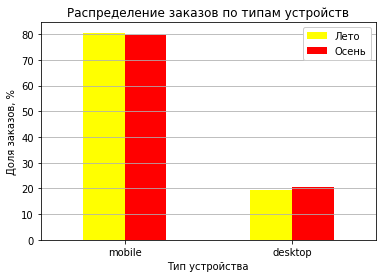

In [32]:
device_summer = summer['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)
device_autumn = autumn['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)

types_comparison = pd.DataFrame({'Лето': device_summer, 'Осень': device_autumn})
display(types_comparison)

plt.figure(figsize=(12, 6))
types_comparison.plot(kind='bar', color=['yellow','red'])
plt.title('Распределение заказов по типам устройств')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов, %')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.legend(framealpha=1)
plt.show()

Промежуточный вывод: сезонность не влияет на выбор устройства — мобильные используются чаще.



Рассмотрим возрастной рейтинг:

,Лето,Осень
0,17.9,23.4
6,18.2,17.7
12,20.6,22.1
16,28.2,26.2
18,15.0,10.5


<Figure size 864x432 with 0 Axes>

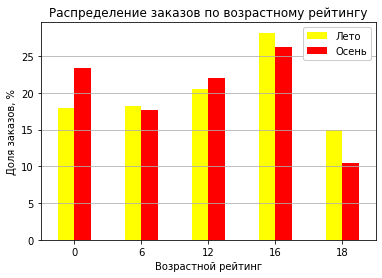

In [33]:
age_summer = summer['age_limit'].value_counts(normalize=True).mul(100).round(1)
age_autumn = autumn['age_limit'].value_counts(normalize=True).mul(100).round(1)

ages_comparison = pd.DataFrame({'Лето': age_summer, 'Осень': age_autumn})
display(ages_comparison)

plt.figure(figsize=(12, 6))
ages_comparison.plot(kind='bar', color=['yellow','red'])
plt.title('Распределение заказов по возрастному рейтингу')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Доля заказов, %')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.legend(framealpha=1)
plt.show()

Промежуточный вывод: категория 0+ увеличивает долю осенью на 5 п.п, вероятно это связано с началом учебного года в школах, категория 6+ почти неизменна, также как и 12+ - небольшой рост осенью на 3 п.п. Интересно, что в старших категориях (16+ и 18+) явный рост летом, более заметный у категории 18% (почти 5 п.п) -  вероятно связано с отпусками и завершением учебного года в ВУЗах. 

Теперь коснемся выручки с продажи 1 билета, посмотрим сезонное распределение и взаимосвязь:

season,Лето,Осень
event_type_main,,
unknown,3.611663,15.055037
выставки,86.416199,91.066620
другое,81.054352,77.044479
концерты,319.094971,286.780090
спорт,54.097149,52.157547
стендап,227.070679,249.963867
театр,222.560074,183.039474
ёлки,276.388214,234.488480


,"Изменение средней выручки с билета (лето-осень), %"
event_type_main,
unknown,316.845032
стендап,10.081970
выставки,5.381417
спорт,-3.585404
другое,-4.947138
концерты,-10.127044
ёлки,-15.159739
театр,-17.757273


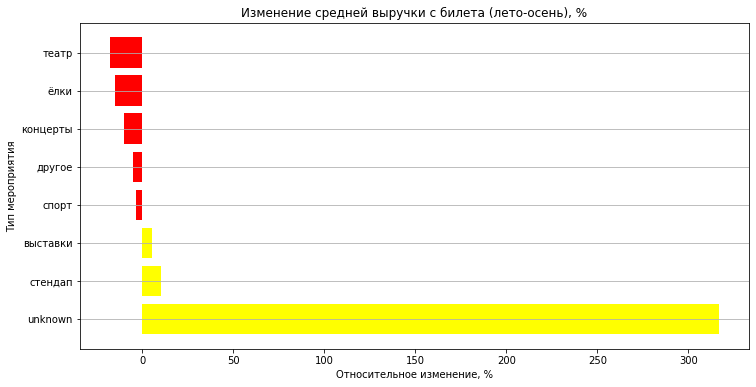

In [34]:
mean_revenue = df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack()
display(mean_revenue)

revenue_change = (mean_revenue['Осень'] / mean_revenue['Лето'] - 1) * 100
revenue_change = revenue_change.sort_values(ascending=False).to_frame('Изменение средней выручки с билета (лето-осень), %')
display (revenue_change)

plt.figure(figsize=(12, 6))
bars = plt.barh(revenue_change.index, revenue_change['Изменение средней выручки с билета (лето-осень), %'], 
                color=np.where(revenue_change['Изменение средней выручки с билета (лето-осень), %'] > 0, 'yellow', 'red'))

plt.title('Изменение средней выручки с билета (лето-осень), %')
plt.xlabel('Относительное изменение, %')
plt.ylabel('Тип мероприятия')
plt.grid(axis='y')


plt.show()

Промежуточный вывод: по таблицам и графику видно падение выручки с билета в 5 категориях осенью (театр, елки, концерты, другое и спорт), 3 категории растут - стендап, выставки и неизвестная категория unknown, у которой рост большее 300%, хотя относительные цифры совсем скромные (рост с 3,6 до 15,05 за билет). Самые высокие выручки с билета в категориях - концерты, ёлки, стендап и театр - большее 200 рублей за билет в среднем осень и летом.

### Осенняя активность пользователей

В это разделе проанализируем следующие параметры: 
 - ежедневную динамику общего числа заказов
 - ежедневную динамику количества активных пользователей DAU
 - ежедневную динамику среднего числа заказов на одного пользователя
 - ежедневную динамику средней стоимости одного билета
 - недельную цикличность активности.
 
 Начнем по порядку:

,date,total_orders
0,2024-09-01,1348
1,2024-09-02,1391
2,2024-09-03,5124
3,2024-09-04,1784
4,2024-09-05,1956
...,...,...
56,2024-10-27,2866
57,2024-10-28,2857
58,2024-10-29,2887
59,2024-10-30,2960


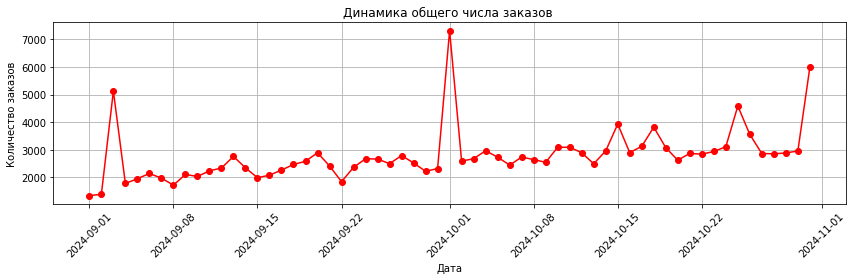

In [35]:
df_fall = df[df['season'] == 'Осень'].copy()

df_fall['date'] = pd.to_datetime(df_fall['created_dt_msk'])  

daily_stats = df_fall.groupby('date').agg(
              total_orders=('order_id', 'count'),
              unique_users=('user_id', 'nunique')).reset_index() 

display(daily_stats[['date', 'total_orders']])

plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['total_orders'], color='red', marker='o')
plt.title('Динамика общего числа заказов ')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Промежуточный вывод: по графику виден тренд на рост числа заказов осенью с несколькими большими пиками (2024-09-01, 2024-10-01, 2024-10-31). Возможно в это время были акционные предложения или выступления известного исполнителя, либо несколько человек сразу заказывали много билетов, что отразилось на графике пиком. Колебания количества заказов происходят в пределах 1500-3000. 

Из предыдущего кода сразу можно рассмотреть DAU:

,date,unique_users
0,2024-09-01,569
1,2024-09-02,580
2,2024-09-03,783
3,2024-09-04,687
4,2024-09-05,745
...,...,...
56,2024-10-27,1039
57,2024-10-28,988
58,2024-10-29,1005
59,2024-10-30,1050


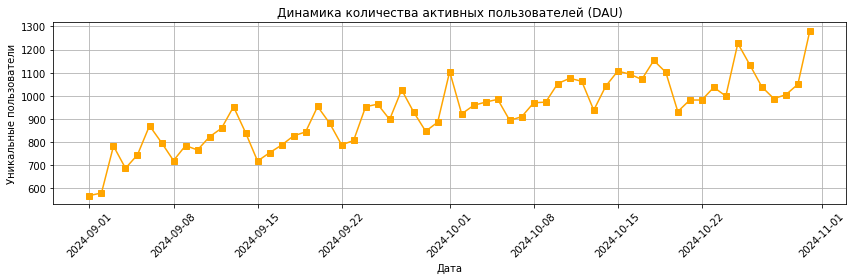

In [36]:
display(daily_stats[['date', 'unique_users']])


plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['unique_users'], color='orange', marker='s')
plt.title('Динамика количества активных пользователей (DAU)')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Промежуточный вывод: также позитивная динамика на рост активных пользователей. Колебания выше, явных пиков нет, как и явных просадок. Диапазон показателей от 700 до 1100.

Продолжим - теперь ежедневная динамика среднего числа заказов на одного пользователя:

0     2.369069
1     2.398276
2     6.544061
3     2.596798
4     2.625503
        ...   
56    2.758422
57    2.891700
58    2.872637
59    2.819048
60    4.670047
Name: orders_per_user, Length: 61, dtype: float64

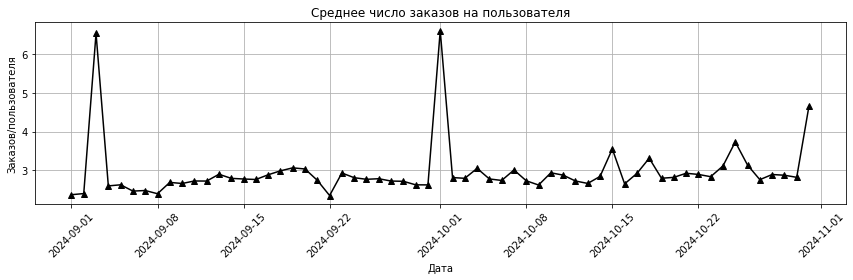

In [37]:
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['unique_users']

display(daily_stats['orders_per_user'])

plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['orders_per_user'], color='black', marker='^')
plt.title('Среднее число заказов на пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователя')
plt.grid()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Промежуточный вывод: динамика похожа на общее число заказов, видно, что среднее количество билетов в заказе составляет почти 3 билета. Некоторые пики имеют среднее высокое значения в те же даты, что и у общего числа заказов.

Ежедневная динамика средней стоимости одного билета:

0     586.309254
1     534.910811
2     233.567477
3     509.841613
4     534.084835
         ...    
56    528.995202
57    500.767151
58    522.669856
59    528.023564
60    402.887256
Name: avg_ticket_price, Length: 61, dtype: float64

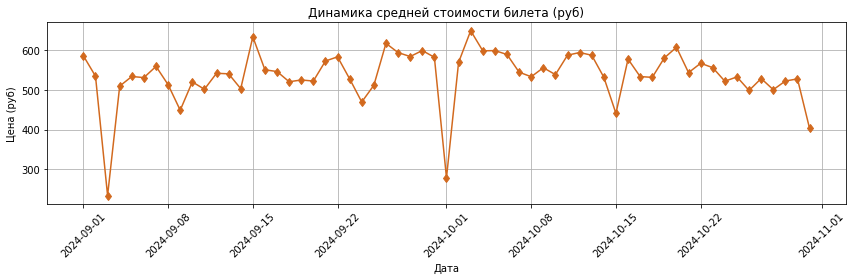

In [38]:
daily_revenue = df_fall.groupby('date')['revenue_rub'].sum().reset_index()

daily_stats['avg_ticket_price'] = daily_revenue['revenue_rub'] / daily_stats['total_orders']
display(daily_stats['avg_ticket_price'])

plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['avg_ticket_price'], color='chocolate', marker='d')
plt.title('Динамика средней стоимости билета (руб)')
plt.xlabel('Дата')
plt.ylabel('Цена (руб)')
plt.grid()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Промежуточный вывод: ситуация немного проясняется и становятся понятны пики - средняя стоимость билета имеет провалы как раз в те даты, где пики по числу заказов. Очевидно предположить, что это была маркетинговая акция, которая давала скидку при покупке большого количества билетов. Также стоит обратить внимание, что до 2024-10-15 показатели относительно стабильны, однако после этой даты веден небольшой спад до конца осени. Стоит обратить на это внимание и стимулировать мероприятия поднимать цены, либо насытить новыми мероприятиями приложение для выравнивания показателя.

Финальное в разделе - недельная цикличность:

In [39]:
df_fall['day_of_week'] = df_fall['date'].dt.dayofweek  
df_fall['day_name'] = df_fall['date'].dt.day_name()  

df_fall['is_weekend'] = df_fall['day_of_week'].isin([5, 6]) 

weekday_stats = df_fall.groupby(['day_name', 'is_weekend']).agg(
                total_orders=('order_id', 'count'),
                unique_users=('user_id', 'nunique'),
                total_revenue=('revenue_rub', 'sum')).reset_index()

weekday_stats['avg_orders_per_user'] = weekday_stats['total_orders'] / weekday_stats['unique_users']
weekday_stats['avg_revenue_per_user'] = weekday_stats['total_revenue'] / weekday_stats['unique_users']

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['day_name'] = pd.Categorical(weekday_stats['day_name'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('day_name')
display (weekday_stats)

,day_name,is_weekend,total_orders,unique_users,total_revenue,avg_orders_per_user,avg_revenue_per_user
1,Monday,False,21700,4475,11501671.0,4.849162,2570.205810
5,Tuesday,False,31724,4817,13057648.0,6.585842,2710.742786
6,Wednesday,False,23105,4850,12456172.0,4.763918,2568.282887
4,Thursday,False,27377,4996,14327629.0,5.479784,2867.820056
0,Friday,False,25060,4897,13877551.0,5.117419,2833.888299
2,Saturday,True,21535,4596,12074452.0,4.685596,2627.165361
3,Sunday,True,19574,4413,11374974.0,4.435531,2577.605710


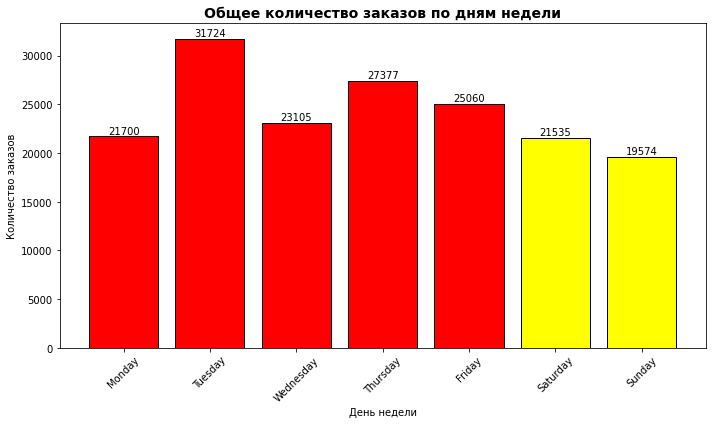

In [40]:
plt.figure(figsize=(10, 6))
colors = ['red' if not weekend else 'yellow' for weekend in weekday_stats['is_weekend']]


plt.bar(weekday_stats['day_name'], weekday_stats['total_orders'], color=colors, edgecolor='black')
plt.title('Общее количество заказов по дням недели', fontsize=14, fontweight='bold')
plt.ylabel('Количество заказов')
plt.xlabel('День недели')
plt.xticks(rotation=45)

for i, v in enumerate(weekday_stats['total_orders']):
    plt.text(i, v + 50, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

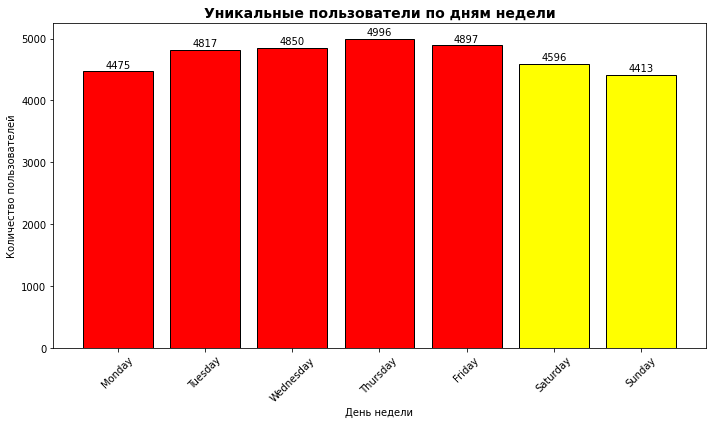

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(weekday_stats['day_name'], weekday_stats['unique_users'], color=colors, edgecolor='black')
plt.title('Уникальные пользователи по дням недели', fontsize=14, fontweight='bold')
plt.ylabel('Количество пользователей')
plt.xlabel('День недели')
plt.xticks(rotation=45)

for i, v in enumerate(weekday_stats['unique_users']):
    plt.text(i, v + 20, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

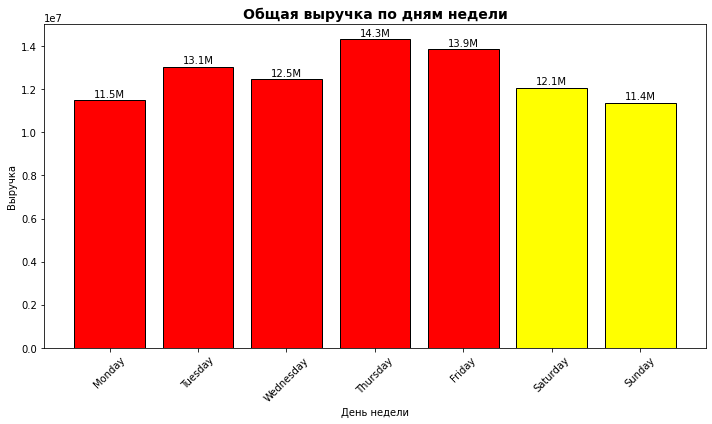

In [42]:
plt.figure(figsize=(10, 6))
plt.bar(weekday_stats['day_name'], weekday_stats['total_revenue'], color=colors, edgecolor='black')
plt.title('Общая выручка по дням недели', fontsize=14, fontweight='bold')
plt.ylabel('Выручка')
plt.xlabel('День недели')
plt.xticks(rotation=45)

for i, v in enumerate(weekday_stats['total_revenue']):
    plt.text(i, v + 50000, f'{v/1e6:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

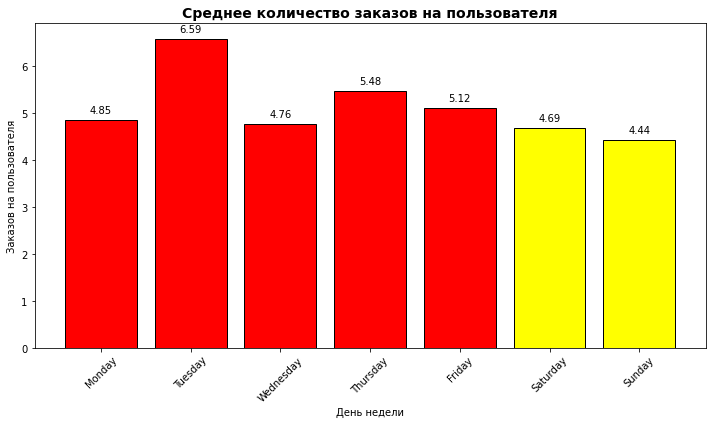

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(weekday_stats['day_name'], weekday_stats['avg_orders_per_user'], color=colors, edgecolor='black')
plt.title('Среднее количество заказов на пользователя', fontsize=14, fontweight='bold')
plt.ylabel('Заказов на пользователя')
plt.xlabel('День недели')
plt.xticks(rotation=45)

for i, v in enumerate(weekday_stats['avg_orders_per_user']):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

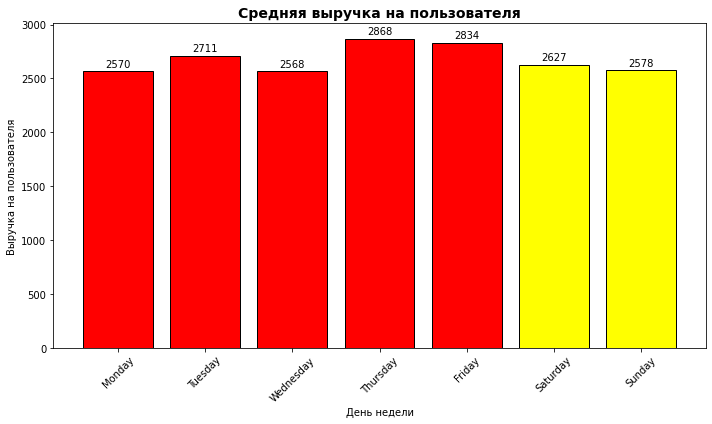

In [44]:
plt.figure(figsize=(10, 6))
plt.bar(weekday_stats['day_name'], weekday_stats['avg_revenue_per_user'], color=colors, edgecolor='black')
plt.title('Средняя выручка на пользователя', fontsize=14, fontweight='bold')
plt.ylabel('Выручка на пользователя')
plt.xlabel('День недели')
plt.xticks(rotation=45)

for i, v in enumerate(weekday_stats['avg_revenue_per_user']):
    plt.text(i, v + 20, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

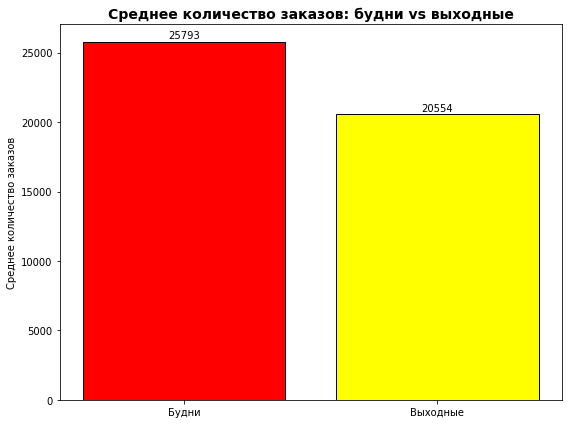

In [45]:
plt.figure(figsize=(8, 6))
weekday_data = weekday_stats[weekday_stats['is_weekend'] == False]['total_orders'].mean()
weekend_data = weekday_stats[weekday_stats['is_weekend'] == True]['total_orders'].mean()

plt.bar(['Будни', 'Выходные'], [weekday_data, weekend_data], color=['red', 'yellow'], edgecolor='black')
plt.title('Среднее количество заказов: будни vs выходные', fontsize=14, fontweight='bold')
plt.ylabel('Среднее количество заказов')

for i, v in enumerate([weekday_data, weekend_data]):
    plt.text(i, v + 100, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Промежуточные выводы: по таблице и графикам недельной динамики можно сделать следующие выводы:
 - больше всего заказов пользователи делают во вторник, четверг и пятницу. Это говорит о том, что люди заранее планируют свой досуг, либо в эти дни запускаются маркетинговые акции, стимуляруя пользователей покупать билеты. В выходные цифры меньше, чем в любой будний день;
 - по уникальных пользователям более ровные значения - во все дни больше 4 300 человек пользуется сервисом. Больше всего пользователей появляется со вторника по пятницу;
 - больше всего выручки приходит в четверг (13,4 млн) и пятницу (13,1 млн), затем вторник (12,7 млн). Во все дни недели выручка больше 10,5 млн. Это интересно. Вероятно площадка повышает цены ближе к мероприятиям, которые проходят в выходные, что и способствует росту выручки. Предположительно - пользователи переплачивают, не планируя заранее свои развлечения;
 - среднее количество заказов на пользователя имеет похожую динамику с общим количеством заказов. В среднем получается больше 4 билетов на пользователя;
 - средняя выручка с пользователя составляет больше 2400 в любой день недели. Больше всего в четверг (2 701), пятницу (2 688) и вторник (2 645);
 - по суммарному отличию среднего количества заказов в будние и выходные: перевес в будние дни на 5 000 заказов. Что логично - в будние подготовились к отдыху, в выходные отдыхаем. 

### Популярные события и партнёры в осенний период

Этот раздел состоит из 2 частей:
 - для каждого региона посчитать уникальное количество мероприятий и общее число заказов
 - для каждого билетного партнёра (оператора) посчитать общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. 
 
Выделим топ-10 регионов и операторов, как это было в дашборде. Также учтем не только абсолютные значения, но и относительные. 
 
Начнем анализ с регионов:

In [46]:
region_stats = df_fall.groupby('region_name').agg(
               unique_events=('event_id', 'nunique'),  
               total_orders=('order_id', 'count'),     
               unique_users=('user_id', 'nunique')).reset_index()


region_stats = region_stats.sort_values('unique_events', ascending=False)

top_10 = region_stats.sort_values('unique_events', ascending=False).head(10)
display(top_10)

,region_name,unique_events,total_orders,unique_users
24,Каменевский регион,3946,47492,7070
60,Североярская область,2619,20834,4026
76,Широковская область,803,8739,2069
57,Светополянский округ,764,4839,1206
52,Речиновская область,529,3575,1032
61,Серебринская область,456,4477,1115
77,Яблоневская область,432,4222,1022
68,Тепляковская область,420,2487,667
12,Горицветская область,406,3235,716
64,Солнечноземская область,403,4232,864


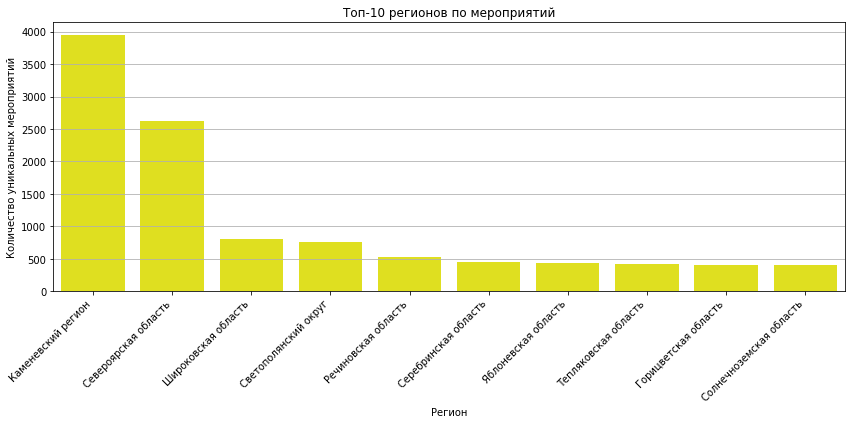

In [47]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=top_10,
                x='region_name',
                y='unique_events',
                color='yellow')

plt.title('Топ-10 регионов по мероприятий')
plt.xlabel('Регион')
plt.ylabel('Количество уникальных мероприятий')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [48]:
total_events = df_fall['event_id'].nunique()
total_orders = df_fall['order_id'].count()

region_stats = df_fall.groupby('region_name').agg(
               region_events=('event_id', 'nunique'),
               region_orders=('order_id', 'count')).reset_index()  

region_stats['events_share'] = (region_stats['region_events'] / total_events * 100).round(2)
region_stats['orders_share'] = (region_stats['region_orders'] / total_orders * 100).round(2)

top_regions_events = region_stats.sort_values('events_share', ascending=False).head(10)
display(top_regions_events[['region_name', 'events_share', 'orders_share']])

,region_name,events_share,orders_share
24,Каменевский регион,24.78,27.92
60,Североярская область,16.45,12.25
76,Широковская область,5.04,5.14
57,Светополянский округ,4.80,2.85
52,Речиновская область,3.32,2.10
61,Серебринская область,2.86,2.63
77,Яблоневская область,2.71,2.48
68,Тепляковская область,2.64,1.46
12,Горицветская область,2.55,1.90
64,Солнечноземская область,2.53,2.49


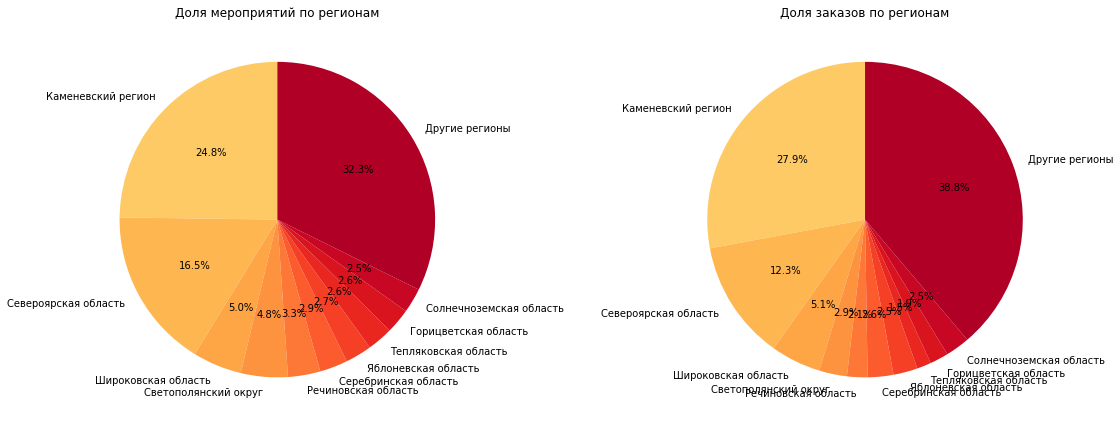

In [49]:
other_events = total_events - top_regions_events['region_events'].sum()
other_orders = total_orders - top_regions_events['region_orders'].sum()

top_with_other = top_regions_events.append({
                'region_name': 'Другие регионы',
                'events_share': (other_events / total_events * 100).round(2),
                'orders_share': (other_orders / total_orders * 100).round(2)}, ignore_index=True)


colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top_with_other)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.pie(top_with_other['events_share'],
        labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90,
        colors = colors)
ax1.set_title('Доля мероприятий по регионам')

ax2.pie(top_with_other['orders_share'],
        labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90,
        colors = colors)
ax2.set_title('Доля заказов по регионам')

plt.tight_layout()
plt.show()

Промежуточный вывод: по доле мероприятий и заказов по регионам - 2 явных лидера: Каменевский регион и Североярская область. Остальные принимают у себя сильно меньше мероприятий (колебания от 5% и менее по мероприятиям и заказам). Возможно в этих регионах не развита инфраструктура для проведения. Поскольку есть 2 сильных лидера - нужно укреплять позиции в них, наращивать результаты. 

Теперь проанализируем операторов:

In [50]:
partner_stats = df_fall.groupby('service_name').agg(
                unique_events=('event_id', 'nunique'),  
                total_orders=('order_id', 'count'),     
                total_revenue=('revenue_rub', 'sum')).reset_index()   


partner_stats['total_revenue'] = partner_stats['total_revenue'].round(2)
partner_stats = partner_stats.sort_values('total_revenue', ascending=False)

pd.set_option('display.float_format', '{:,.2f}'.format)

top_10_partners = partner_stats.sort_values('unique_events', ascending=False).head(10)


display(top_10_partners)

,service_name,unique_events,total_orders,total_revenue
21,Лови билет!,3626,25867,"10,644,124.00"
3,Билеты без проблем,2852,32724,"13,556,004.00"
5,Билеты в руки,2474,25761,"7,713,814.00"
25,Облачко,1413,15616,"12,459,031.00"
22,Лучшие билеты,1397,12459,"1,739,533.50"
24,Мой билет,1010,19661,"11,792,202.00"
30,Тебе билет!,859,3779,"2,223,909.25"
26,Прачечная,728,5831,"2,647,691.50"
8,Весь в билетах,608,9642,"10,170,589.00"
34,Яблоко,538,3496,"2,831,861.50"


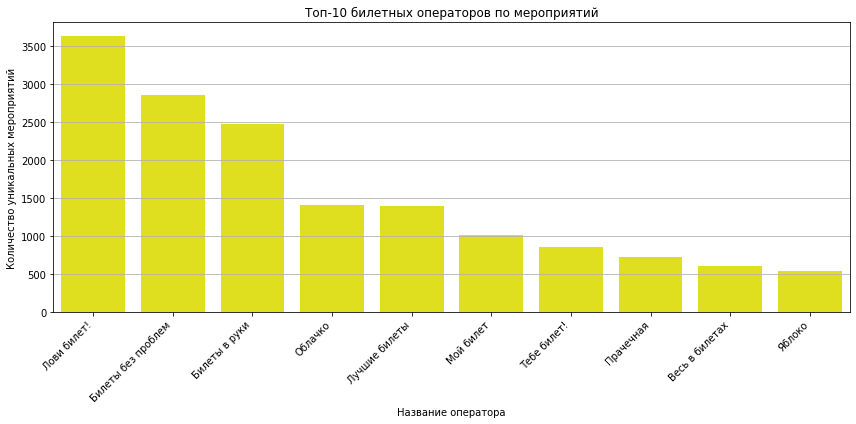

In [51]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=top_10_partners,
                x='service_name',
                y='unique_events',
                color='yellow')

plt.title('Топ-10 билетных операторов по мероприятий')
plt.xlabel('Название оператора')
plt.ylabel('Количество уникальных мероприятий')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [52]:
top_10_partners = partner_stats.sort_values('unique_events', ascending=False).head(10).copy()

total_events = partner_stats['unique_events'].sum()
total_orders = partner_stats['total_orders'].sum()
total_revenue = partner_stats['total_revenue'].sum()

top_10_partners['Доля событий, %'] = (top_10_partners['unique_events'] / total_events * 100).round(1)
top_10_partners['Доля заказов, %'] = (top_10_partners['total_orders'] / total_orders * 100).round(1)
top_10_partners['Доля выручки, %'] = (top_10_partners['total_revenue'] / total_revenue * 100).round(1)

top_10_partners = top_10_partners.rename(columns={
    'service_name': 'Билетный оператор (партнер)',
    'unique_events': 'Уникальные события',
    'total_orders': 'Всего заказов',
    'total_revenue': 'Выручка, руб'})

display(top_10_partners[['Билетный оператор (партнер)', 'Уникальные события', 'Доля событий, %', 
                    'Всего заказов', 'Доля заказов, %', 
                    'Выручка, руб', 'Доля выручки, %']])

,Билетный оператор (партнер),Уникальные события,"Доля событий, %",Всего заказов,"Доля заказов, %","Выручка, руб","Доля выручки, %"
21,Лови билет!,3626,20.90,25867,15.20,"10,644,124.00",12.00
3,Билеты без проблем,2852,16.40,32724,19.20,"13,556,004.00",15.30
5,Билеты в руки,2474,14.30,25761,15.10,"7,713,814.00",8.70
25,Облачко,1413,8.10,15616,9.20,"12,459,031.00",14.10
22,Лучшие билеты,1397,8.10,12459,7.30,"1,739,533.50",2.00
24,Мой билет,1010,5.80,19661,11.60,"11,792,202.00",13.30
30,Тебе билет!,859,5.00,3779,2.20,"2,223,909.25",2.50
26,Прачечная,728,4.20,5831,3.40,"2,647,691.50",3.00
8,Весь в билетах,608,3.50,9642,5.70,"10,170,589.00",11.50
34,Яблоко,538,3.10,3496,2.10,"2,831,861.50",3.20


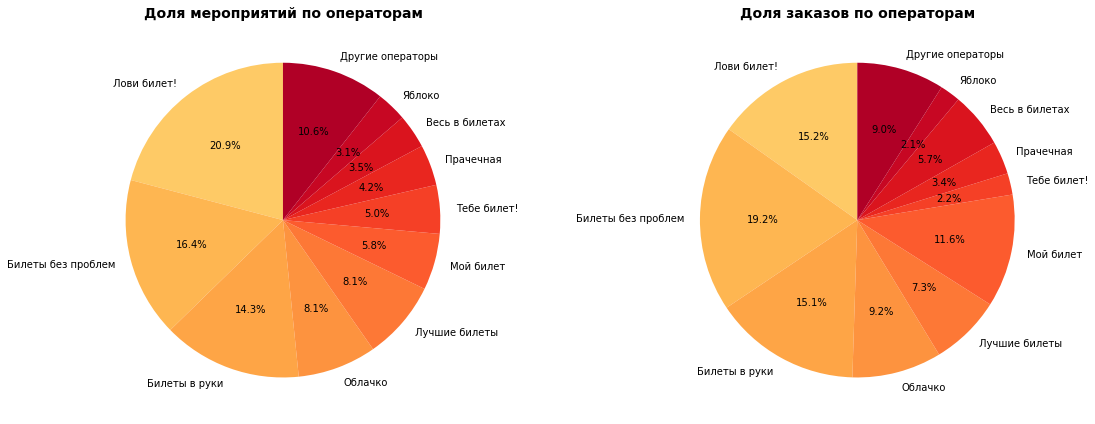

In [53]:
other_events = total_events - top_10_partners['Уникальные события'].sum()
other_orders = total_orders - top_10_partners['Всего заказов'].sum()

other_data = {
    'Билетный оператор (партнер)': 'Другие операторы',
    'Доля событий, %': (other_events / total_events * 100).round(1),
    'Доля заказов, %': (other_orders / total_orders * 100).round(1)
}

top_with_other_part = top_10_partners.append(other_data, ignore_index=True)


colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top_with_other_part)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.pie(top_with_other_part['Доля событий, %'],
        labels=top_with_other_part['Билетный оператор (партнер)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors)
ax1.set_title('Доля мероприятий по операторам', fontsize=14, fontweight='bold')


ax2.pie(top_with_other_part['Доля заказов, %'],
        labels=top_with_other_part['Билетный оператор (партнер)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors)
ax2.set_title('Доля заказов по операторам', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Промежуточный вывод: с партнерами ситуация более-менее стабильнее, однако 3 билетных оператора забирают себе почти половину рынка по мероприятиям и заказам - "Лови билет!", "Билеты без проблем", "Билеты в руки". Для остальных компаний это должно быть стимулом к росту и развитию команд, также, возможно, к ним не идут клиенты для проведения мероприятий из-за меньших возможностей или доверия, ценовой политике. У "Лови билет!" покупают билеты на большее количество мероприятий и это составляет почти 21% всего рынка, однако по доле заказов лидер другой - "Билеты без проблем" (19,2% рынка по доле заказов), что может говорить о более выгодных условиях у этого оператора. 

## Статистический анализ данных

Команда продукта заинтересована в проверке следующих гипотез:

 - среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями ПК (1-я гипотеза)
 - среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК (2-я гипотеза)

Для тестирования гипотез необходимо провести проверку данных, предварительная проверка будет включать в себя:

 - пересечения в группах, очистка групп при необходимости
 - подбор теста (с опорой на распределение в выборках)
 - формулирование нулевой и альтернативной гипотез и проведение теста

### 1-я гипотеза

Приступим к проверке 1-й гипотезы. Посмотрим на группы:

In [54]:
desktop_group_users = df_fall[df_fall['device_type_canonical'] == 'desktop']['user_id']
mobile_group_users = df_fall[df_fall['device_type_canonical'] == 'mobile']['user_id']

intersection = list(set(desktop_group_users) & set(mobile_group_users))
print(f'Размер группы ПК - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')
print(f'Пересечения в группах: {len(intersection)}')

Размер группы ПК - 4905, мобильных устройств - 14235
Пересечения в группах: 3273


Есть пересечения между группами и пользователей ПК в несколько раз меньше, чем пользователей мобильных устройств. 

Уже при таком условии есть предпосылка использовать тест Манна-Уитни (проверим распределения, чтобы точно использовать этот метод). Уберем пересечения между группами:

In [55]:
desktop_group_users = desktop_group_users[~desktop_group_users.isin(intersection)]
mobile_group_users = mobile_group_users[~mobile_group_users.isin(intersection)]

print(f'Итоговый размер группы ПК - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')

Итоговый размер группы ПК - 1632, мобильных устройств - 10962


Сформируем окончательные группы и посмотрим распределения:

In [56]:
desktop_group_1 = df_fall[df_fall['user_id'].isin(desktop_group_users)].groupby('user_id', as_index=False).agg({'order_id': 'nunique'})
mobile_group_1 = df_fall[df_fall['user_id'].isin(mobile_group_users)].groupby('user_id', as_index=False).agg({'order_id': 'nunique'})

print(desktop_group_1.describe(percentiles=[.95, .99]))
print(mobile_group_1.describe(percentiles=[.95, .99]))

       order_id
count  1,632.00
mean       1.98
std        3.06
min        1.00
50%        1.00
95%        5.00
99%       12.00
max       56.00
       order_id
count 10,962.00
mean       2.87
std        4.11
min        1.00
50%        2.00
95%        9.00
99%       20.00
max      123.00


Данные имеют выбросы, явно скошенны влево.

Формулируем нулевую и альтернативную гипотезы для теста:

Н0: Среднее количество заказов на пользователя мобильных устройств не выше среднего количества заказов ПК

Н1: Среднее количество заказов на пользователя мобильных устройств выше среднего количества заказов ПК

Проведем статистический тест Манна-Уитни (односторонний), задав базовый уровень значимости 0,05:

In [57]:
alpha = 0.05

stat_test, p_value_mannwhitneyu = mannwhitneyu(
    mobile_group_1['order_id'],
    desktop_group_1['order_id'],
    alternative='greater'
)

if p_value_mannwhitneyu > alpha:
    print(f'{p_value_mannwhitneyu=:.5f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.5f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.00000. Принимаем альтернативную гипотезу


Промежуточный вывод: результат теста говорит о том, что есть основания предполагать, что пользователи мобильных устройств покупают больше билетов, принимаем альтернативную гипотезу - среднее количество заказов на пользователя мобильных устройств выше среднего количества заказов ПК.

### 2-я гипотеза

Приступим к проверке 2-й гипотезы. Для этой гипотезы нужно предварительно сформировать выборки данных с непересекающимися пользователями и отфильтровать пропуски в столбце days_since_prev. Посмотрим на группы:

In [58]:
desktop_group_2 = df_fall[(df_fall['user_id'].isin(desktop_group_users)) & (~df_fall['days_since_prev'].isna())]
mobile_group_2 = df_fall[(df_fall['user_id'].isin(mobile_group_users)) & (~df_fall['days_since_prev'].isna())]

print(desktop_group_2['days_since_prev'].describe())
print(mobile_group_2['days_since_prev'].describe())

count   2,093.00
mean       18.12
std        32.72
min         0.00
25%         0.00
50%         0.00
75%        23.00
max       146.00
Name: days_since_prev, dtype: float64
count   24,740.00
mean        13.81
std         25.71
min          0.00
25%          0.00
50%          1.00
75%         15.00
max        148.00
Name: days_since_prev, dtype: float64


Данные имеют выбросы, тоже явно скошенны влево.

Формулируем нулевую и альтернативную гипотезы для теста:

Н0: Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями ПК

Н1: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК


Проведем статистический тест Манна-Уитни (односторонний), задав базовый уровень значимости 0,05:

In [59]:
alpha = 0.05

stat_test, p_value_mannwhitneyu = mannwhitneyu(
    mobile_group_2['days_since_prev'],
    desktop_group_2['days_since_prev'],
    alternative='greater'
)

if p_value_mannwhitneyu > alpha:
    print(f'{p_value_mannwhitneyu=:.5f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.5f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.00000. Принимаем альтернативную гипотезу


Промежуточный вывод: результат теста говорит о том, что есть основания предполагать, что среднее время между заказами у пользователей мобильных утсройств выше, чем у пользователей ПК, принимаем альтернативную гипотезу - среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК.

## Итоговый вывод и рекомендации

### Итоговый вывод

Проведен исследовательский анализ данных сервиса бронирования билетов Яндекс.Афиша за период с 1 июня по 30 октября 2024 года, выявлены причины изменений в пользовательском спросе, определены ключевые факторы, влияющие на популярность мероприятий, и проанализирована активность пользователей, как с мобильных, так и с десктопных устройств.

В результате анализа произведено сравнение сезонных изменений, выделение лидеров по выручке, а также определение особенностей поведения пользователей в зависимости от различных факторов, таких как тип мероприятия, устройство, возрастное ограничение и прочие инсайды. 

Анализ проводился по 3 датасетам, которые были предобработаны, объединены, определены и удалены пропуски, дубликаты, выявлены распределения, оптимизированы типы данных, созданы нужные для анализа столбцы:

 - удалено 1% данных (выбросы). Итоговый объем - 287 725 строк;
 - объеденены датафреймы df_orders, df_events в один df df_merged;
 - пропуски: days_since_prev ~ 8%, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данныe; в строковых столбцах event_name, event_type_description, event_type_main, organizers, region_name, city_name, venue_name, venue_address, для которых event_id не найдены;
 - столбцы с датами created_dt_msk,created_ts_msk, data преобразованы в тип datetime;
 - оптимизирована размерность в столбцах age_limit,tickets_count, revenue, total;
 - в количественных столбцах revenue и total c выручкой и общей суммой заказа выявлены отрицательные значения, которые могли быть образованы в результате возвратов битетов;
 - по столбцу revenue с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив репрезентативность;
 - дубликаты: явных нет, неявные - 30 (удалены);
 - созданы новые столбцы: revenue_rub — выручка с заказа к единой валюте (российский рубль),one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие, month — месяц оформления заказа, season — сезон.
 

Далее проведен исследовательский анализ данных следующих параметров:

 - анализ распределения заказов по сегментам и их сезонные изменения;
 - осенняя активность пользователей;
 - популярные события и партнеры.
 
Выводы по исследовательскому анализу данных:
 
 - отчетливо виден рост количестве заказов к осени. Причем в процентном соотношение июня к ноябрю - рост большее 200%; летом явные лидеры: концерты (41,8%), другое (27,1%) и театр (20,4%), осенью распределение похоже, лидирующие категория те же, однако заметен резкий рост спортивных мероприятий, рост с летом больше в 5 раз (2,5% -> 11,1%); сезонность не влияет на выбор устройства — мобильные используются чаще; категория 0+ увеличивает долю осенью на 5 п.п, вероятно это связано с началом учебного года в школах, категория 6+ почти неизменна, также как и 12+ - небольшой рост осенью на 3 п.п. Интересно, что в старших категориях (16+ и 18+) явный рост летом, более заметный у категории 18% (почти 5 п.п) - вероятно связано с отпусками и завершением учебного года в ВУЗах; падение выручки с билета в 5 категориях осенью (театр, елки, концерты, другое и спорт), 3 категории растут - стендап, выставки и неизвестная категория unknown, у которой рост большее 300%, хотя относительные цифры совсем скромные (рост с 3,6 до 15,05 за билет); самые высокие выручки с билета в категориях - концерты, ёлки, стендап и театр - большее 200 рублей за билет в среднем осень и летом; 
 - виден тренд на рост числа заказов осенью с несколькими большими пиками (2024-09-01, 2024-10-01, 2024-10-31). Возможно в это время были акционные предложения или выступления известного исполнителя, либо несколько человек сразу заказывали много билетов, что отразилось на графике пиком. Колебания количества заказов происходят в пределах 1500-3000; также позитивная динамика на рост активных пользователей. Колебания выше, явных пиков нет, как и явных просадок. Диапазон показателей от 700 до 1100; динамика среднего количества билетов похожа на общее число заказов, среднее количество билетов в заказе составляет почти 3 билета. Некоторые пики имеют среднее высокое значения в те же даты, что и у общего числа заказов; ситуация немного проясняется после анализа стоимости билетов и становятся понятны пики - средняя стоимость билета имеет провалы как раз в те даты, где пики по числу заказов. Очевидно предположить, что это была маркетинговая акция, которая давала скидку при покупке большого количества билетов. Также стоит обратить внимание, что до 2024-10-15 показатели относительно стабильны, однако после этой даты веден небольшой спад до конца осени; больше всего заказов пользователи делают во вторник, четверг и пятницу. Это говорит о том, что люди заранее планируют свой досуг, либо в эти дни запускаются маркетинговые акции, стимуляруя пользователей покупать билеты. В выходные цифры меньше, чем в любой будний день; по уникальным пользователям более ровные значения - во все дни больше 4 300 человек пользуется сервисом. Больше всего пользователей появляется со вторника по пятницу; больше всего выручки приходит в четверг (13,4 млн) и пятницу (13,1 млн), затем вторник (12,7 млн). Во все дни недели выручка больше 10,5 млн. Это интересно. Вероятно площадка повышает цены ближе к мероприятиям, которые проходят в выходные, что и способствует росту выручки. Предположительно - пользователи переплачивают, не планируя заранее свои развлечения; среднее количество заказов на пользователя имеет похожую динамику с общим количеством заказов. В среднем получается больше 4 билетов на пользователя; средняя выручка с пользователя составляет больше 2400 в любой день недели. Больше всего в четверг (2 701), пятницу (2 688) и вторник (2 645); по суммарному отличию среднего количества заказов в будние и выходные: перевес в будние дни на 5 000 заказов. Что логично - в будние подготовились к отдыху, в выходные отдыхаем.
 - по доле мероприятий и заказов по регионам - 2 явных лидера: Каменевский регион и Североярская область. Остальные принимают у себя сильно меньше мероприятий (колебания от 5% и менее по мероприятиям и заказам в общем рынке). Возможно в этих регионах не развита инфраструктура для проведения; с партнерами ситуация более-менее стабильнее, однако 3 билетных оператора забирают себе почти половину рынка по мероприятиям и заказам - "Лови билет!", "Билеты без проблем", "Билеты в руки". У "Лови билет!" покупают билеты на большое количество мероприятий и это составляет почти 20,9% всего рынка, однако по доле заказов лидер другой - "Билеты без проблем" (19,2% рынка по доле заказов), что может говорить о более выгодных условиях у этого оператора.
 
Далее проведен статистический анализ данных следующих гипотез:

 - среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств (1-я гипотеза)
 - среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств (2-я гипотеза)
 
Выводы по исследовательскому анализу данных говорят о том, что:
 - есть основания предполагать, что пользователи мобильных устройств покупают больше билетов, принята альтернативная гипотеза - среднее количество заказов на пользователя мобильных устройств выше среднего количества заказов ПК;
 - есть основания предполагать, что среднее время между заказами у пользователей мобильных утсройств выше, чем у пользователей ПК, принята альтернативная гипотеза - среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК.
 

### Рекомендации

 - равномерно заполнять информацию по мероприятиям для более детального и полного анализа, ведь достаточно большое количество мероприятий в категориии unknown. Эта категория самая неопределенная, однако у нее самый большой прирост выручки от лета к осени среди всех категорий;
 - увеличивать доли других событий, помимо популярных, наполнять сервис; 
 - лучше подбирать рекомендации для пользователей, учитывая сезонность и возраст, обратить внимание на категорию 18+, ведь там самые малые доли заказов;
 - улучшать мобильное приложение, ведь подавляющая доля заказов происходит через мобильные устройства, возможно предлагать более выгодные предложения при заказе через телефон;
 - равномерно по времени и размеру скидок планировать акции и маркетинговые предложения, ведь сейчас видны явные пики, которые положительно влияют на количество заказов, однако негативно влияют на выручку. Думаю это не очень хорошая тенденция, ведь бизнес должен зарабатывать, учитывать недельную динамику пользовательской активности - сосредоточится на будних днях, например среде и четвергу. 
 - стараться расширять географию мест для проведения мероприятий, ведь зависимость от 2-х регионов может со временем сыграть во вред. Возможно стоит предлагать пользователям из других регионов мероприятия из лидеров - дублировать. Однако в лидирующих регионах по доле мероприятий и заказов старатся не потерять позиции и укреплятся;
 - расширить долю партнеров (операторов), стимулировать рост компаний, которые занимают меньшую долю на рынке заказов и мероприятий;
